# Introduction to Classical Artificial Intelligence 
# 1 - Search and Uninformed and Informed Search Strategies

This notebook is a modified version of the Search4e notebook of the AIMA 4th edition repository (https://github.com/aimacode/aima-python).
This notebook focuses on path planning problems.

# Problems and Nodes

We start by defining the abstract class for a `Problem`; specific problem domains will subclass this. To make it easier for algorithms that use a heuristic evaluation function, `Problem` has a default `h` function (uniformly zero), and subclasses can define their own default `h` function.

We also define a `Node` in a search tree, and some functions on nodes: `expand` to generate successors; `path_actions` and `path_states`  to recover aspects of the path from the node.  

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import random
import heapq
import math
import sys
from collections import defaultdict, deque, Counter
from itertools import combinations


class Problem(object):
    """The abstract class for a formal problem. A new domain subclasses this,
    overriding `actions` and `results`, and perhaps other methods.
    The default heuristic is 0 and the default action cost is 1 for all states.
    When yiou create an instance of a subclass, specify `initial`, and `goal` states 
    (or give an `is_goal` method) and perhaps other keyword args for the subclass."""

    def __init__(self, initial=None, goal=None, **kwds): 
        self.__dict__.update(initial=initial, goal=goal, **kwds) 
        
    def actions(self, state):        raise NotImplementedError
    def result(self, state, action): raise NotImplementedError
    def is_goal(self, state):        return state == self.goal
    def action_cost(self, s, a, s1): return 1
    def h(self, node):               return 0
    
    def __str__(self):
        return '{}({!r}, {!r})'.format(
            type(self).__name__, self.initial, self.goal)
    

class Node:
    "A Node in a search tree."
    def __init__(self, state, parent=None, action=None, path_cost=0):
        self.__dict__.update(state=state, parent=parent, action=action, path_cost=path_cost)

    def __repr__(self): return '<{}>'.format(self.state)
    def __len__(self): return 0 if self.parent is None else (1 + len(self.parent))
    def __lt__(self, other): return self.path_cost < other.path_cost
    
    
failure = Node('failure', path_cost=math.inf) # Indicates an algorithm couldn't find a solution.
cutoff  = Node('cutoff',  path_cost=math.inf) # Indicates iterative deepening search was cut off.
    
    
def expand(problem, node):
    "Expand a node, generating the children nodes."
    s = node.state
    for action in problem.actions(s):
        s1 = problem.result(s, action)
        cost = node.path_cost + problem.action_cost(s, action, s1)
        yield Node(s1, node, action, cost)
        

def path_actions(node):
    "The sequence of actions to get to this node."
    if node.parent is None:
        return []  
    return path_actions(node.parent) + [node.action]


def path_states(node):
    "The sequence of states to get to this node."
    if node in (cutoff, failure, None): 
        return []
    return path_states(node.parent) + [node.state]

# Queues

First-in-first-out and Last-in-first-out queues, and a `PriorityQueue`, which allows you to keep a collection of items, and continually remove from it the item with minimum `f(item)` score.

In [2]:
FIFOQueue = deque

LIFOQueue = list

class PriorityQueue:
    """A queue in which the item with minimum f(item) is always popped first."""

    def __init__(self, items=(), key=lambda x: x): 
        self.key = key
        self.items = [] # a heap of (score, item) pairs
        for item in items:
            self.add(item)
         
    def add(self, item):
        """Add item to the queuez."""
        pair = (self.key(item), item)
        heapq.heappush(self.items, pair)

    def pop(self):
        """Pop and return the item with min f(item) value."""
        return heapq.heappop(self.items)[1]
    
    def top(self): return self.items[0][1]

    def __len__(self): return len(self.items)

# Search Algorithms: Best-First

Best-first search with various *f(n)* functions gives us different search algorithms. Note that A\*, weighted A\* and greedy search can be given a heuristic function, `h`, but if `h` is not supplied they use the problem's default `h` function (if the problem does not define one, it is taken as *h(n)* = 0).

In [3]:
def best_first_search(problem, f):
    "Search nodes with minimum f(node) value first."
    node = Node(problem.initial)
    frontier = PriorityQueue([node], key=f)
    reached = {problem.initial: node}
    while frontier:
        node = frontier.pop()
        if problem.is_goal(node.state):
            return node
        for child in expand(problem, node):
            s = child.state
            if s not in reached or child.path_cost < reached[s].path_cost:
                reached[s] = child
                frontier.add(child)
    return failure


def best_first_tree_search(problem, f):
    "A version of best_first_search without the `reached` table."
    frontier = PriorityQueue([Node(problem.initial)], key=f)
    while frontier:
        node = frontier.pop()
        if problem.is_goal(node.state):
            return node
        for child in expand(problem, node):
            if not is_cycle(child):
                frontier.add(child)
    return failure


def g(n): return n.path_cost


def astar_search(problem, h=None):
    """Search nodes with minimum f(n) = g(n) + h(n)."""
    h = h or problem.h
    return best_first_search(problem, f=lambda n: g(n) + h(n))


def astar_tree_search(problem, h=None):
    """Search nodes with minimum f(n) = g(n) + h(n), with no `reached` table."""
    h = h or problem.h
    return best_first_tree_search(problem, f=lambda n: g(n) + h(n))


def weighted_astar_search(problem, h=None, weight=1.4):
    """Search nodes with minimum f(n) = g(n) + weight * h(n)."""
    h = h or problem.h
    return best_first_search(problem, f=lambda n: g(n) + weight * h(n))

        
def greedy_bfs(problem, h=None):
    """Search nodes with minimum h(n)."""
    h = h or problem.h
    return best_first_search(problem, f=h)


def uniform_cost_search(problem):
    "Search nodes with minimum path cost first."
    return best_first_search(problem, f=g)


def breadth_first_bfs(problem):
    "Search shallowest nodes in the search tree first; using best-first."
    return best_first_search(problem, f=len)


def depth_first_bfs(problem):
    "Search deepest nodes in the search tree first; using best-first."
    return best_first_search(problem, f=lambda n: -len(n))


def is_cycle(node, k=30):
    "Does this node form a cycle of length k or less?"
    def find_cycle(ancestor, k):
        return (ancestor is not None and k > 0 and
                (ancestor.state == node.state or find_cycle(ancestor.parent, k - 1)))
    return find_cycle(node.parent, k)



# Other Search Algorithms

Here are the other search algorithms:

In [4]:
def breadth_first_search(problem):
    "Search shallowest nodes in the search tree first."
    node = Node(problem.initial)
    if problem.is_goal(problem.initial):
        return node
    frontier = FIFOQueue([node])
    reached = {problem.initial}
    while frontier:
        node = frontier.pop()
        for child in expand(problem, node):
            s = child.state
            if problem.is_goal(s):
                return child
            if s not in reached:
                reached.add(s)
                frontier.appendleft(child)
    return failure


def iterative_deepening_search(problem):
    "Do depth-limited search with increasing depth limits."
    for limit in range(1, sys.maxsize):
        result = depth_limited_search(problem, limit)
        if result != cutoff:
            return result
        
        
def depth_limited_search(problem, limit=5):
    "Search deepest nodes in the search tree first."
    frontier = LIFOQueue([Node(problem.initial)])
    result = failure
    while frontier:
        node = frontier.pop()
        if problem.is_goal(node.state):
            return node
        elif len(node) >= limit:
            result = cutoff
        elif not is_cycle(node):
            for child in expand(problem, node):
                frontier.append(child)
    return result


def depth_first_recursive_search(problem, node=None):
    if node is None: 
        node = Node(problem.initial)
    if problem.is_goal(node.state):
        return node
    elif is_cycle(node):
        return failure
    else:
        for child in expand(problem, node):
            result = depth_first_recursive_search(problem, child)
            if result:
                return result
        return failure

# Problem Domains

Here we just focus on path plannning problems, other problems can be found in the Search4e notebook of the AIMA 4th edition repository (https://github.com/aimacode/aima-python). 

Problem domains are defined as subclasses of `Problem`.

# Grid Problems

A `GridProblem` involves navigating on a 2D grid, with some cells being impassible obstacles. By default you can move to any of the *eight* neighboring cells that are not obstacles (but in a problem instance you can supply a `directions=` keyword to change that). Again, the default heuristic is straight-line distance to the goal. States are `(x, y)` cell locations, such as `(4, 2)`, and actions are `(dx, dy)` cell movements, such as `(0, -1)`, which means leave the `x` coordinate alone, and decrement the `y` coordinate by 1.

In [5]:
def straight_line_distance(A, B):
    "Straight-line distance between two points."
    return sum(abs(a - b)**2 for (a, b) in zip(A, B)) ** 0.5

In [6]:
def manhattan_distance(A, B):
    """The Manhattan distance between two points."""
    return sum(abs(a - b) for (a, b) in zip(A, B))    

In [7]:
class GridProblem(Problem):
    """Finding a path on a 2D grid with obstacles. Obstacles are (x, y) cells."""

    def __init__(self, initial=(15, 30), goal=(130, 30), obstacles=(), **kwds):
        Problem.__init__(self, initial=initial, goal=goal, 
                         obstacles=set(obstacles) - {initial, goal}, **kwds)

    directions = [(-1, -1), (0, -1), (1, -1),
                  (-1, 0),           (1,  0),
                  (-1, +1), (0, +1), (1, +1)]
    
    directionsuplr = [(0, -1), (-1, 0), (0, 1), (1,0)]
    
    def action_cost(self, s, action, s1): return straight_line_distance(s, s1)
    
    def h(self, node): return straight_line_distance(node.state, self.goal)
    
    def hmd(self, node): return manhattan_distance(node.state, self.goal)
                  
    def result(self, state, action): 
        "Both states and actions are represented by (x, y) pairs."
        return action if action not in self.obstacles else state
    
    def actions(self, state):
        """You can move one cell in any of `directions` to a non-obstacle cell."""
        x, y = state
        return {(x + dx, y + dy) for (dx, dy) in self.directionsuplr} - self.obstacles

In [8]:
# Some grid routing problems

# The following can be used to create obstacles:
    
def random_lines(X=range(15, 130), Y=range(60), N=150, lengths=range(6, 12)):
    """The set of cells in N random lines of the given lengths."""
    result = set()
    for _ in range(N):
        x, y = random.choice(X), random.choice(Y)
        dx, dy = random.choice(((0, 1), (1, 0)))
        result |= line(x, y, dx, dy, random.choice(lengths))
    return result

def line(x, y, dx, dy, length):
    """A line of `length` cells starting at (x, y) and going in (dx, dy) direction."""
    return {(x + i * dx, y + i * dy) for i in range(length)}

random.seed(42) # To make this reproducible

frame = line(-10, 20, 0, 1, 20) | line(150, 20, 0, 1, 20)
cup = line(102, 44, -1, 0, 15) | line(102, 20, -1, 0, 20) | line(102, 44, 0, -1, 24)

d0 = GridProblem(initial=(2,8), goal=(14, 3), obstacles=random_lines(X=range(5,15), Y=range(5,10), N=10, lengths=range(2,3)))
d1 = GridProblem(obstacles=random_lines(N=100) | frame)
d2 = GridProblem(obstacles=random_lines(N=150) | frame)
d3 = GridProblem(obstacles=random_lines(N=200) | frame)
d4 = GridProblem(obstacles=random_lines(N=250) | frame)
d5 = GridProblem(obstacles=random_lines(N=300) | frame)
d6 = GridProblem(obstacles=cup | frame)
d7 = GridProblem(obstacles=cup | frame | line(50, 35, 0, -1, 10) | line(60, 37, 0, -1, 17) | line(70, 31, 0, -1, 19))

In [9]:
def transpose(matrix): return list(zip(*matrix))

def show_map(gr):
    plt.figure(figsize=(8, 5))
    plt.axis('off'); plt.axis('equal')
    plt.scatter(*transpose(gr.obstacles), marker='s', color='darkgrey')
    plt.scatter(*transpose([gr.initial]), 9**2, marker='D', c='green')
    plt.scatter(*transpose([gr.goal]), 9**2, marker='8', c='red')
    plt.show()
    return


# Reporting Summary Statistics on Search Algorithms

Now let's gather some metrics on how well each algorithm does.  We'll use `CountCalls` to wrap a `Problem` object in such a way that calls to its methods are delegated to the original problem, but each call increments a counter. Once we've solved the problem, we print out summary statistics.

In [10]:
class CountCalls:
    """Delegate all attribute gets to the object, and count them in ._counts"""
    def __init__(self, obj):
        self._object = obj
        self._counts = Counter()
        
    def __getattr__(self, attr):
        "Delegate to the original object, after incrementing a counter."
        self._counts[attr] += 1
        return getattr(self._object, attr)

        
def report(searchers, problems, verbose=True):
    """Show summary statistics for each searcher (and on each problem unless verbose is false)."""
    for searcher in searchers:
        print(searcher.__name__ + ':')
        total_counts = Counter()
        for p in problems:
            prob   = CountCalls(p)
            soln   = searcher(prob)
            counts = prob._counts; 
            counts.update(actions=len(soln), cost=soln.path_cost)
            total_counts += counts
            if verbose: report_counts(counts, str(p)[:40])
        report_counts(total_counts, 'TOTAL\n')
        
def report_counts(counts, name):
    """Print one line of the counts report."""
    print('{:9,d} nodes |{:9,d} goal |{:5.0f} cost |{:8,d} actions | {}'.format(
          counts['result'], counts['is_goal'], counts['cost'], counts['actions'], name))
    


In [11]:
def astar_straight_line_distance(problem): return astar_search(problem, h=problem.h)
def astar_manhattan_distance(problem): return astar_search(problem, h=problem.hmd)

# Comparing different weighted search values

Below we report on problems using these four algorithms:

|Algorithm|*f*|Optimality|
|:---------|---:|:----------:|
|Greedy best-first search | *f = h*|nonoptimal|
|Extra weighted A* search | *f = g + 2 &times; h*|nonoptimal|
|Weighted A* search | *f = g + 1.4 &times; h*|nonoptimal|
|A* search | *f = g + h*|optimal|
|Uniform-cost search | *f = g*|optimal|

We will see that greedy best-first search (which ranks nodes solely by the heuristic) explores the fewest number of nodes, but has the highest path costs. Weighted A* search explores twice as many nodes (on this problem set) but gets 10% better path costs. A* is optimal, but explores more nodes, and uniform-cost is also optimal, but explores an order of magnitude more nodes.

In [12]:
def extra_weighted_astar_search(problem): return weighted_astar_search(problem, weight=2)

# Visualizing Reached States

I would like to draw a picture of the state space, marking the states that have been reached by the search.
Unfortunately, the *reached* variable is inaccessible inside `best_first_search`, so I will define a new version of `best_first_search` that is identical except that it declares *reached* to be `global`. I can then define `plot_grid_problem` to plot the obstacles of a `GridProblem`, along with the initial and goal states, the solution path, and the states reached during a search.

In [13]:
def best_first_search(problem, f):
    "Search nodes with minimum f(node) value first."
    global reached # <<<<<<<<<<< Only change here
    node = Node(problem.initial)
    frontier = PriorityQueue([node], key=f)
    reached = {problem.initial: node}
    while frontier:
        node = frontier.pop()
        if problem.is_goal(node.state):
            return node
        for child in expand(problem, node):
            s = child.state
            if s not in reached or child.path_cost < reached[s].path_cost:
                reached[s] = child
                frontier.add(child)
    return failure


def plot_grid_problem(grid, solution, reached=(), title='Search', show=True):
    "Use matplotlib to plot the grid, obstacles, solution, and reached."
    reached = list(reached)
    plt.figure(figsize=(8, 5))
    plt.axis('off'); plt.axis('equal')
    plt.scatter(*transpose(grid.obstacles), marker='s', color='darkgrey')
    plt.scatter(*transpose(reached), 1**2, marker='.', c='blue')
    plt.scatter(*transpose(path_states(solution)), marker='s', c='blue')
    plt.scatter(*transpose([grid.initial]), 9**2, marker='D', c='green')
    plt.scatter(*transpose([grid.goal]), 9**2, marker='8', c='red')
    if show: plt.show()
    print('{} {} search: {:.1f} path cost, {:,d} states reached'
          .format(' ' * 10, title, solution.path_cost, len(reached)))
    
def plots(grid, weights=(1.2, 2)): 
    """Plot the results of 4 heuristic search algorithms for this grid."""
    solution = astar_search(grid)
    plot_grid_problem(grid, solution, reached, 'A* search')
    for weight in weights:
        solution = weighted_astar_search(grid, weight=weight)
        plot_grid_problem(grid, solution, reached, '(b) Weighted ({}) A* search'.format(weight))
    solution = greedy_bfs(grid)
    plot_grid_problem(grid, solution, reached, 'Greedy best-first search')

<h1>Final Test</h1>

<h2>Question 1</h2>

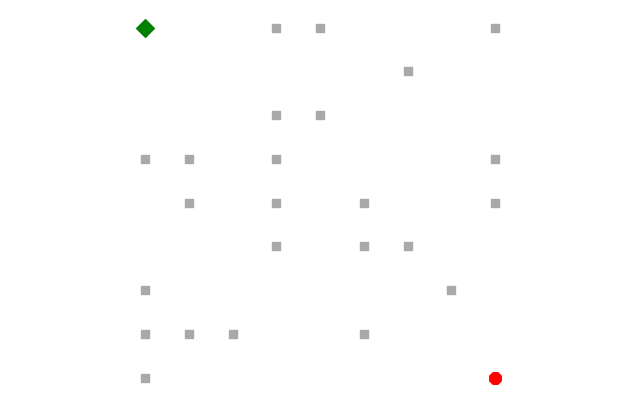

In [14]:
# Define the initial position, goal position, and obstacles for your 9x9 grid
initial_position = (0, 8)
goal_position = (8, 0)
obstacles = set([(0, 0), (0, 1), (0, 2), (0, 5),
                 (1, 1), (1, 4), (1, 5), 
                 (2, 1), 
                 (3, 3), (3, 4), (3, 5), (3, 6), (3, 8),
                 (4, 6), (4, 8), 
                 (5, 1), (5, 3), (5, 4),
                 (6, 3), (6, 7), 
                 (7, 2),
                 (8, 4), (8, 5), (8, 8)
                 ])

# Create an instance of the GridProblem class with the defined parameters
problem_grid = GridProblem(initial=initial_position, goal=goal_position, obstacles=obstacles)

show_map(problem_grid)

In [15]:
report([
    uniform_cost_search,
    astar_straight_line_distance,
    astar_manhattan_distance,
    astar_search,
    astar_tree_search,
    breadth_first_search,
    breadth_first_bfs,
    greedy_bfs,
    weighted_astar_search,
    extra_weighted_astar_search,
    depth_limited_search
], [problem_grid])

uniform_cost_search:
    1,876 nodes |      487 goal |   16 cost |     502 actions | GridProblem((0, 8), (8, 0))
    1,876 nodes |      487 goal |   16 cost |     502 actions | TOTAL

astar_straight_line_distance:
      221 nodes |       69 goal |   16 cost |      84 actions | GridProblem((0, 8), (8, 0))
      221 nodes |       69 goal |   16 cost |      84 actions | TOTAL

astar_manhattan_distance:
      131 nodes |       43 goal |   16 cost |      58 actions | GridProblem((0, 8), (8, 0))
      131 nodes |       43 goal |   16 cost |      58 actions | TOTAL

astar_search:
      221 nodes |       69 goal |   16 cost |      84 actions | GridProblem((0, 8), (8, 0))
      221 nodes |       69 goal |   16 cost |      84 actions | TOTAL

astar_tree_search:
    2,125 nodes |      668 goal |   16 cost |     683 actions | GridProblem((0, 8), (8, 0))
    2,125 nodes |      668 goal |   16 cost |     683 actions | TOTAL

breadth_first_search:
    1,687 nodes |    1,688 goal |   16 cost |     455

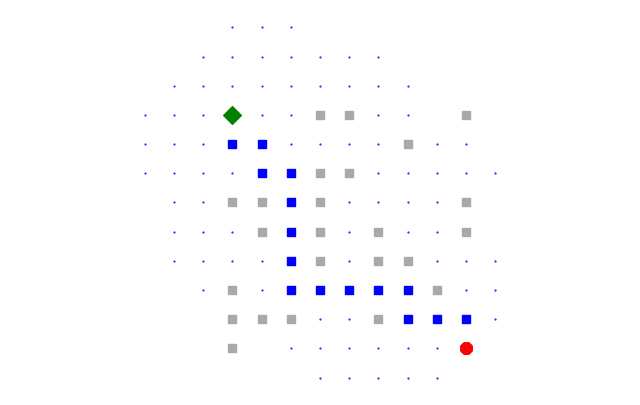

           A* search search: 16.0 path cost, 99 states reached


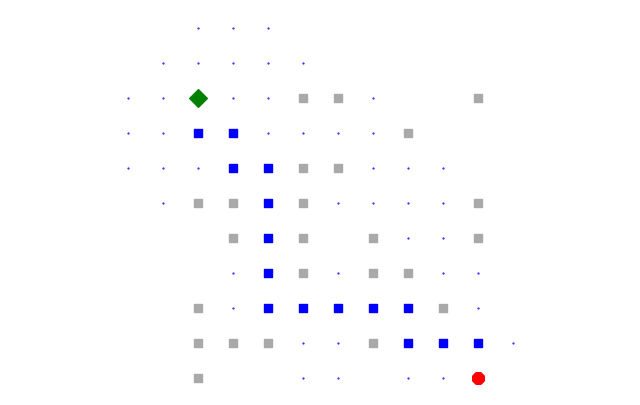

           (b) Weighted (1.2) A* search search: 16.0 path cost, 62 states reached


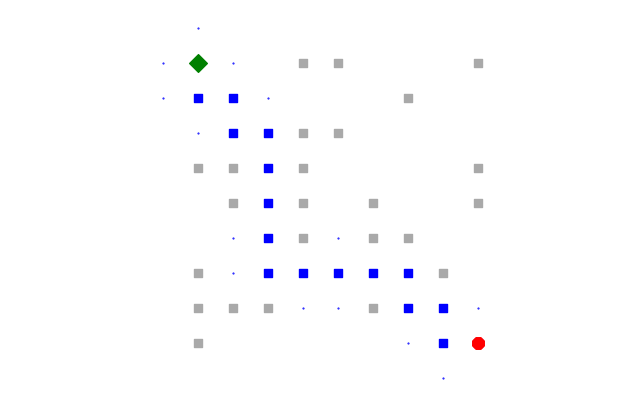

           (b) Weighted (2) A* search search: 16.0 path cost, 31 states reached


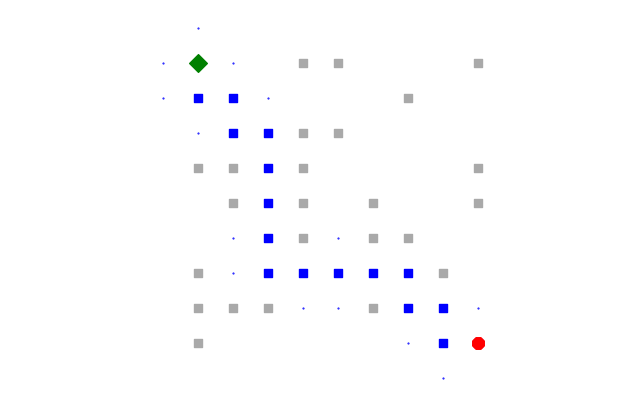

           Greedy best-first search search: 16.0 path cost, 31 states reached


In [16]:
plots(problem_grid)